# Main Notebook

File to perform experiments

## Imports

In [34]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd

from models.GaussianProcess import GaussianProcess
from acquisition_functions.MES import mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOcrossit, MOOquadratic
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

## Algorithm Arguments

In [35]:
d = 1
    
seed = 0
np.random.seed(seed)

total_iter = 19
initial_iter = 1

lower_bound = -5
upper_bound = 5

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

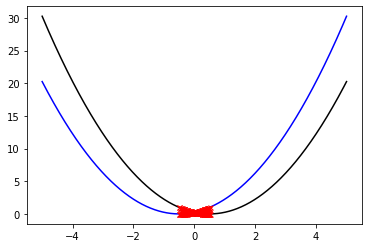

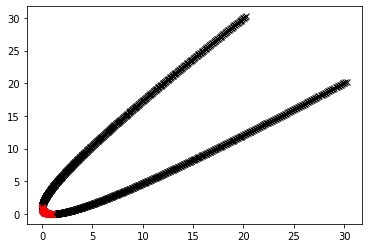

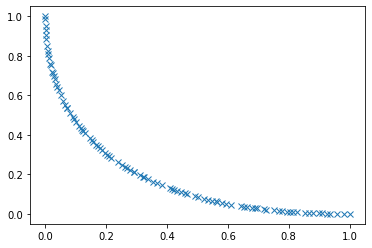

In [36]:
T=1.

def evaluation(x):
    return MOOquadratic(x, c1=-T/2, c2=T/2)

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

O = 2
C = 0

problem = MOOEvaluationProblem(evaluation, lowerBound=lower_bound, upperBound=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

plt.plot(X, Z[:,0], 'b')
plt.plot(X, Z[:,1], 'k')
plt.plot(res.X, res.F[:,0], 'xr', markersize=5)
plt.plot(res.X, res.F[:,1], 'xr', markersize=5)
plt.show()

plt.plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
plt.plot(res.F[:,0], res.F[:,1], 'rx')
plt.show()

plt.plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

## Initialize model

In [ ]:
## Kernerl configuration 
k = gpflow.kernels.SquaredExponential()
### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, k, noise_variance=2e-6)

### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_rand = evaluation(x_rand)
    GP.addSample(x_rand,y_rand)

GP.updateGPR()
GP.optimizeKernel()
GP.plotSamples()

## Main Loop

In [ ]:
distancias = []
ds1 = []
ds2 = []

for l in range(total_iter):
    
    ## Search of the best acquisition function
    x_best, acq_best = mes_acq(GP, showplots = True)
    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)
    
    ## UPDATE
    GP.addSample(x_best,y_best)      ## Add new sample to the model
    GP.updateGPR()                                          ## Update data on the GP regressor
    GP.optimizeKernel()                                     ## Optimize kernel hyperparameters

    _, distancia, d1, d2 = GP.evaluatePareto(real_pareto, showparetos = True)
    distancias.append(distancia)
    ds1.append(d1)
    ds2.append(d2)

In [ ]:
savename = "exp"

idxs = [i for i,_ in enumerate(distancias)]

plt.plot(idxs, distancias)
plt.plot(idxs, ds1)
plt.plot(idxs, ds2)
plt.show()


df = pd.DataFrame({'d': distancias, 'd1': ds1, 'd2':ds2})
df.to_csv("./CSVs/"+savename+".csv")

## N experiments

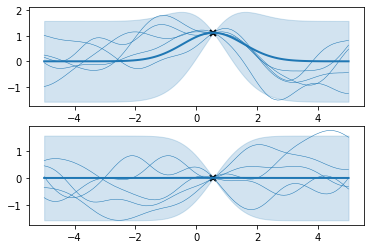

distancia1 0.35358233552896356
distancia2 1.0004650751633906


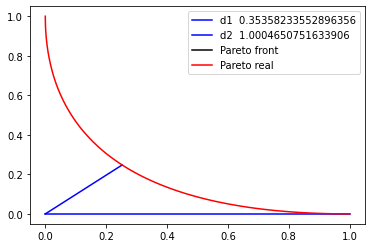

distancia1 0.7529235242750766
distancia2 1.1205461254954887
distancia1 0.16542947362945437
distancia2 1.2043261762437822
distancia1 0.5028504789085866
distancia2 0.7494437451978324
distancia1 0.014417837144652109
distancia2 0.02523116755383984
distancia1 0.01790144230850761
distancia2 0.019170786292420933
distancia1 0.018160172537582096
distancia2 0.016335438612597147
distancia1 0.017299680467722987
distancia2 0.027055308282905845
distancia1 0.017155601544957908
distancia2 0.024119223339580585
distancia1 0.01675953442553856
distancia2 0.014635851830258147
distancia1 0.016574647171288114
distancia2 0.01802628090416477
distancia1 0.018602702729472186
distancia2 0.015039091026309265
distancia1 0.015697060834433858
distancia2 0.020135312191917883
distancia1 0.014944802904704617
distancia2 0.017075112012833377
distancia1 0.016305934645340914
distancia2 0.018911216821321082
distancia1 0.01790578477744089
distancia2 0.017709776846353845
distancia1 0.014178189536318692
distancia2 0.02053793787

<Figure size 432x288 with 0 Axes>

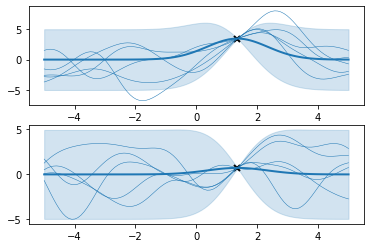

distancia1 0.35358248753258453
distancia2 1.000465288521456


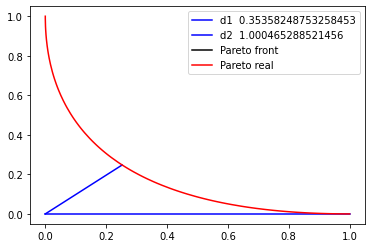

distancia1 0.34973794733712876
distancia2 0.9983842931741242
distancia1 0.8805636805466022
distancia2 1.5388689866975154
distancia1 0.40163885050423026
distancia2 0.7764007230816786
distancia1 0.018742334057298127
distancia2 0.01811120945985891
distancia1 0.01651157131515144
distancia2 0.017137277624818037
distancia1 0.014234892945433576
distancia2 0.017315358861862643
distancia1 0.019058440552316654
distancia2 0.025595123395225548
distancia1 0.015518430908962889
distancia2 0.025873262916022228
distancia1 0.018338731926471
distancia2 0.01562304797967124
distancia1 0.017902859872560156
distancia2 0.020229069853233195
distancia1 0.014328168174827684
distancia2 0.01390746426432939
distancia1 0.015359686272320195
distancia2 0.020117022497147717
distancia1 0.01753153598443468
distancia2 0.020359776386430755
distancia1 0.01879892387969931
distancia2 0.01976647627631825
distancia1 0.01678265086932775
distancia2 0.0211923063360839
distancia1 0.016976697565565847
distancia2 0.01990306971284973


<Figure size 432x288 with 0 Axes>

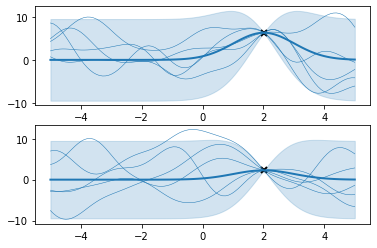

distancia1 0.35358249263246655
distancia2 1.0004652944557466


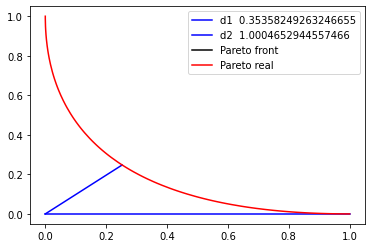

distancia1 0.29245852542423567
distancia2 0.9574953487956073
distancia1 0.6854227553011154
distancia2 0.6593413838891153
distancia1 0.25646497247675504
distancia2 0.28922935761237856
distancia1 0.014365888767400505
distancia2 0.02899446481768977
distancia1 0.015729711353585144
distancia2 0.02419298634486182
distancia1 0.015154907494421901
distancia2 0.018809753226324912
distancia1 0.015471769450630607
distancia2 0.01544585599081656
distancia1 0.015990284495812145
distancia2 0.018757775594623785
distancia1 0.017235871957787315
distancia2 0.015404131294863186
distancia1 0.01547577007841205
distancia2 0.01739309420601207
distancia1 0.016314372021223187
distancia2 0.02439514456996331
distancia1 0.014890891764907764
distancia2 0.01775631055611062
distancia1 0.01726640360578836
distancia2 0.018279876070917682
distancia1 0.016860102145168674
distancia2 0.016645683779396247
distancia1 0.015066705567285683
distancia2 0.023585493515118846
distancia1 0.01672021185291682
distancia2 0.0161037171043

<Figure size 432x288 with 0 Axes>

In [39]:
df = None

for i in range(3):
    ## Kernerl configuration 
    k = gpflow.kernels.SquaredExponential()
    ### GPs Initialization
    GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, k, noise_variance=2e-6)

    #### Initial samples, at least 1
    for l in range(initial_iter):
        ## Get random evaluation point
        while True:
            x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
            if GP.X is None or not x_rand in GP.X:
                break
        ## EVALUATION OF THE OUTSIDE FUNCTION
        y_rand = evaluation(x_rand)
        GP.addSample(x_rand,y_rand)

    GP.updateGPR()
    GP.optimizeKernel()
    GP.plotSamples()

    distancias = []
    ds1 = []
    ds2 = []
    ns = []

    _, distancia, d1, d2 = GP.evaluatePareto(real_pareto, showparetos = True)
    distancias.append(distancia)
    ds1.append(d1)
    ds2.append(d2)
    ns.append(len(GP.X))

    for l in range(total_iter):
        
        ## Search of the best acquisition function
        x_best, acq_best = mes_acq(GP, showplots = False)
        ## EVALUATION OF THE OUTSIDE FUNCTION
        y_best = evaluation(x_best)
        
        ## UPDATE
        GP.addSample(x_best,y_best)     ## Add new sample to the model
        GP.updateGPR()                  ## Update data on the GP regressor
        GP.optimizeKernel()             ## Optimize kernel hyperparameters

        _, distancia, d1, d2 = GP.evaluatePareto(real_pareto, showparetos = False)
        distancias.append(distancia)
        ds1.append(d1)
        ds2.append(d2)
        ns.append(len(GP.X))

    if df is None:
        df = pd.DataFrame({'ns': ns, 'd': distancias, 'd1': ds1, 'd2':ds2})
    else:
        df = df.append(pd.DataFrame({'ns': ns, 'd': distancias, 'd1': ds1, 'd2':ds2}), ignore_index=True)

In [40]:
df

,ns,d,d1,d2
0,1,1.000465,0.353582,1.000465
1,2,1.120546,0.752924,1.120546
2,3,1.204326,0.165429,1.204326
3,4,0.749444,0.502850,0.749444
4,5,0.025231,0.014418,0.025231
5,6,0.019171,0.017901,0.019171
6,7,0.018160,0.018160,0.016335
7,8,0.027055,0.017300,0.027055
8,9,0.024119,0.017156,0.024119
9,10,0.016760,0.016760,0.014636


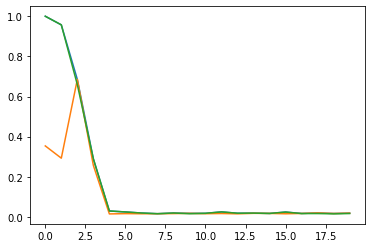

In [41]:
savename = "exp"

idxs = [i for i,_ in enumerate(distancias)]

plt.plot(idxs, distancias)
plt.plot(idxs, ds1)
plt.plot(idxs, ds2)
plt.show()


# df = pd.DataFrame({'d': distancias, 'd1': ds1, 'd2':ds2})
# df.to_csv("./CSVs/"+savename+".csv")